Nguyen Ngoc Tieu Long

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
import sklearn.metrics as metrics

# START: DATA GATHERING

In [2]:
# Các thuộc tính của dataset
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [3]:
# Load dataset
origin_train_dataFrame = pd.read_csv("NSL_KDD_Train.csv", header=None, names=col_names)
origin_test_dataFrame = pd.read_csv("NSL_KDD_Test.csv", header=None, names=col_names)
# origin_train_dataFrame.drop("score",axis=1,inplace=True)
# origin_test_dataFrame.drop("score",axis=1,inplace=True)
print(origin_train_dataFrame.shape)
print(origin_test_dataFrame.shape)

(125973, 42)
(22544, 42)


Nhóm các features vào 3 nhóm

In [4]:
# nominal features: 2 - 3 - 4
# binary features: 7 - 12 - 14 - 15 - 21
# Còn lại là numeric features
nominal_features = ["protocol_type", "service", "flag"]
binary_features = ["land", "logged_in", "root_shell",
                   "su_attempted", "is_host_login", "is_guest_login"]
numeric_features = []
for feature in col_names:
    if ((feature not in nominal_features) and (feature not in binary_features) and (feature != "label")):
        numeric_features.append(feature)

In [5]:
# Liệt kê các features theo từng nhóm
print("Nominal feature (", len(nominal_features), "): ", nominal_features, sep="")
print("Binary features (", len(binary_features), "): ", binary_features, sep="")
print("Numeric features (", len(numeric_features), "): ", numeric_features, sep="")

Nominal feature (3): ['protocol_type', 'service', 'flag']
Binary features (6): ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
Numeric features (32): ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


Chia lại các record vào 4 phân lớp tấn công

In [6]:
# Xem sự phân phối các subclass
print(origin_train_dataFrame["label"].unique())
print(origin_test_dataFrame["label"].unique())

trainLabels = origin_train_dataFrame["label"].tolist()
testLabels = origin_test_dataFrame["label"].tolist()

differentLabels = list(set(testLabels) - set(trainLabels))
print(differentLabels)
# N19DCAT033 - Tran Viet Hoang

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']
['httptunnel', 'udpstorm', 'apache2', 'snmpguess', 'processtable', 'mailbomb', 'sqlattack', 'ps', 'saint', 'snmpgetattack', 'sendmail', 'xlock', 'named', 'mscan', 'xterm', 'worm', 'xsnoop']


In [7]:
# Trước tiên cần phải liệt kê danh sách các subclass của 4 phân lớp DoS, Probe, U2R, R2L
# Tấn công DoS
label_DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb',
             'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
# Tấn công thu thập thông tin
label_Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
# Tấn công chiếm quyền, leo thang đặc quyền
label_U2R = ['buffer_overflow', 'loadmodule',
             'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
# Tấn công kết nối truy cập từ xa
label_R2L = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf',
             'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']

Tách column label thành labels2 (normal - attack) và labels5 (normal - DoS, Probe, R2L, U2R)

In [8]:
attack_labels = []
attack_labels.extend(label_DoS)
attack_labels.extend(label_Probe)
attack_labels.extend(label_U2R)
attack_labels.extend(label_R2L)

In [9]:
# Đối với TRAIN DATASET
origin_train_dataFrame.rename(columns={"label": "labels2"}, inplace=True)
trainLabels2Column = origin_train_dataFrame["labels2"].tolist()
origin_train_dataFrame["labels5"] = trainLabels2Column
origin_train_dataFrame["labels2"].replace(attack_labels, "attack", inplace=True)


In [10]:
# Đối với TEST DATASET
origin_test_dataFrame.rename(columns={"label": "labels2"}, inplace=True)
testLabels2Column = origin_test_dataFrame["labels2"].tolist()
origin_test_dataFrame["labels5"] = testLabels2Column
origin_test_dataFrame["labels2"].replace(attack_labels, "attack", inplace=True)

In [11]:
print(origin_train_dataFrame["labels2"].unique())
print(origin_train_dataFrame["labels5"].unique())
print()
print(origin_test_dataFrame["labels2"].unique())
print(origin_test_dataFrame["labels5"].unique())

['normal' 'attack']
['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']

['attack' 'normal']
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']


In [12]:
# Đối với TRAIN DATASET
# Chia các record vào DoS
origin_train_dataFrame["labels5"].replace(label_DoS, "DoS", inplace=True)
# Chia các record vào Probe
origin_train_dataFrame["labels5"].replace(label_Probe, "Probe", inplace=True)
# Chia các record vào U2R
origin_train_dataFrame["labels5"].replace(label_U2R, "U2R", inplace=True)
# Chia các record vào R2L
origin_train_dataFrame["labels5"].replace(label_R2L, "R2L", inplace=True)

# Đối với TEST DATASET
# Chia các record vào DoS
origin_test_dataFrame["labels5"].replace(label_DoS, "DoS", inplace=True)
# Chia các record vào Probe
origin_test_dataFrame["labels5"].replace(label_Probe, "Probe", inplace=True)
# Chia các record vào U2R
origin_test_dataFrame["labels5"].replace(label_U2R, "U2R", inplace=True)
# Chia các record vào R2L
origin_test_dataFrame["labels5"].replace(label_R2L, "R2L", inplace=True)

normal    67343
attack    58630
Name: labels2, dtype: int64


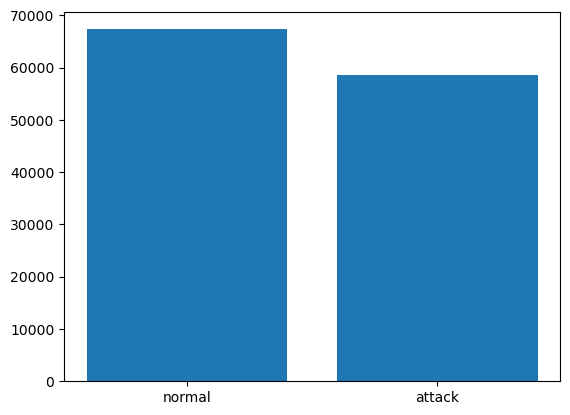

In [13]:
# Xem sự phân phối theo normal - attack
print(origin_train_dataFrame["labels2"].value_counts())
# Vẽ biểu đồ phân phối theo normal - attack
x_label_distribute = np.array(
    origin_train_dataFrame["labels2"].value_counts().index.tolist())
y_label_distribute = np.array(
    origin_train_dataFrame["labels2"].value_counts().values.tolist())
plt.bar(x_label_distribute, y_label_distribute)
plt.show()

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: labels5, dtype: int64


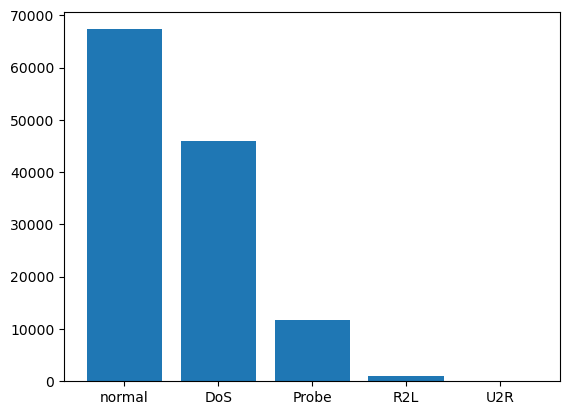

In [14]:
# Xem lại sự phân phối theo lớp tấn công
print(origin_train_dataFrame["labels5"].value_counts())
# Vẽ biểu đồ phân phối theo lớp tấn công
x_label_distribute = np.array(
    origin_train_dataFrame["labels5"].value_counts().index.tolist())
y_label_distribute = np.array(
    origin_train_dataFrame["labels5"].value_counts().values.tolist())
plt.bar(x_label_distribute, y_label_distribute)
plt.show()

# END: DATA GATHERING

# START: DATA PROCESSING

In [15]:
# N19DCAT033 - Tran Viet Hoang
# Trong dataset nsl-kdd có 3 thuộc tính nominal (string) nên không thể thực hiện tính toán các chỉ số trực tiếp
# Sử dụng one-hot encoding để chuyển các nominal attribute sang numeric attribute
# Các feature được scale để tránh việc các feature mang giá trị quá lớn ảnh hưởng tới kết quả của mô hình

In [16]:
# Số lượng các giá trị khác nhau trong 3 nominal attribute
print("\nNumber of unique values in TRAIN DATASET for nominal attributes")
for col in origin_train_dataFrame.columns:
    if origin_train_dataFrame[col].dtypes == 'object' and col != "labels2" and col != "labels5":
        unique_cat = len(origin_train_dataFrame[col].unique())
        print("Feature '{col}' has {unique_cat} categories".format(
            col=col, unique_cat=unique_cat))

print("\nNumber of unique values in TEST DATASET for nominal attributes")
for col in origin_test_dataFrame.columns:
    if origin_test_dataFrame[col].dtypes == 'object' and col != "labels2" and col != "labels5":
        unique_cat = len(origin_test_dataFrame[col].unique())
        print("Feature '{col}' has {unique_cat} categories".format(
            col=col, unique_cat=unique_cat))


Number of unique values in TRAIN DATASET for nominal attributes
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories

Number of unique values in TEST DATASET for nominal attributes
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories


In [17]:
# Với TRAIN DATASET thì sẽ có tổng cộng 3+70+11=84 dummies khi sử dụng one-hot encoding
# Với TEST DATASET thì sẽ có tổng cộng 3+64+11=78 dummies khi sử dụng one-hot encoding

Đưa các nominal (categorical) feature vào mảng numpy 2D (2D numpy array)

In [18]:
train_dataset_categorical_values = origin_train_dataFrame[nominal_features]
test_dataset_categorical_values = origin_test_dataFrame[nominal_features]

print(train_dataset_categorical_values.head())

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF


THỰC HIỆN DUMMY CÁC COLUMN (ATTRIBUTE)

In [19]:
# protocol type
unique_protocol = sorted(origin_train_dataFrame.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2 = [string1 + x for x in unique_protocol]
# service
unique_service = sorted(origin_train_dataFrame.service.unique())
string2 = 'service_'
unique_service2 = [string2 + x for x in unique_service]
# flag
unique_flag = sorted(origin_train_dataFrame.flag.unique())
string3 = 'flag_'
unique_flag2 = [string3 + x for x in unique_flag]
# Put together
dumcols = unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [20]:
# Tương tự với TEST DATASET nhưng ở service chỉ có 64 giá trị khác nhau
unique_service_test = sorted(origin_test_dataFrame.service.unique())
unique_service2_test = [string2 + x for x in unique_service_test]
testdumcols = unique_protocol2 + unique_service2_test + unique_flag2

Chuyển categorical feature sang numerical sử dụng LabelEncoder()

In [21]:
dataset_train_categorical_values_enc = train_dataset_categorical_values.apply(
    LabelEncoder().fit_transform)
# test set
dataset_test_categorical_values_enc = test_dataset_categorical_values.apply(
    LabelEncoder().fit_transform)
print(dataset_train_categorical_values_enc.head())

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


ONE-HOT ENCODING

In [22]:
enc = OneHotEncoder()
# TRAIN DATASET
dataset_train_categorical_values_encenc = enc.fit_transform(
    dataset_train_categorical_values_enc)
dataset_train_cat_data = pd.DataFrame(
    dataset_train_categorical_values_encenc.toarray(), columns=dumcols)
# TEST DATASET
dataset_test_categorical_values_encenc = enc.fit_transform(
    dataset_test_categorical_values_enc)
dataset_test_cat_data = pd.DataFrame(
    dataset_test_categorical_values_encenc.toarray(), columns=testdumcols)

print(dataset_train_cat_data)

        Protocol_type_icmp  Protocol_type_tcp  Protocol_type_udp  service_IRC  \
0                      0.0                1.0                0.0          0.0   
1                      0.0                0.0                1.0          0.0   
2                      0.0                1.0                0.0          0.0   
3                      0.0                1.0                0.0          0.0   
4                      0.0                1.0                0.0          0.0   
...                    ...                ...                ...          ...   
125968                 0.0                1.0                0.0          0.0   
125969                 0.0                0.0                1.0          0.0   
125970                 0.0                1.0                0.0          0.0   
125971                 0.0                1.0                0.0          0.0   
125972                 0.0                1.0                0.0          0.0   

        service_X11  servic

Thêm 6 giá trị category trong attribute service từ TRAIN DATASET vào TEST DATASET

In [23]:
trainservice = origin_train_dataFrame['service'].tolist()
testservice = origin_test_dataFrame['service'].tolist()
difference = list(set(trainservice) - set(testservice))
string = 'service_'
difference = [string + x for x in difference]
print(difference)
for col in difference:
    dataset_test_cat_data[col] = 0

['service_harvest', 'service_red_i', 'service_urh_i', 'service_http_8001', 'service_aol', 'service_http_2784']


Join encoded categorical dataframe với các dataframe khác

In [24]:
newdf = origin_train_dataFrame.join(dataset_train_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test = origin_test_dataFrame.join(dataset_test_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
# Shape sẽ thay đổi, tăng column
print(origin_train_dataFrame.shape)
print(origin_test_dataFrame.shape)
print(newdf.shape)
print(newdf_test.shape)

(125973, 43)
(22544, 43)
(125973, 124)
(22544, 124)


Đặt lại giá trị cho label 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R

In [25]:
# Lấy label column
labels5df = newdf['labels5']
labels5df_test = newdf_test['labels5']

labels2df = newdf['labels2']
labels2df_test = newdf_test['labels2']
# Đổi label column
newlabels5df = labels5df.replace(
    {'normal': 0, 'DoS': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4})
newlabels5df_test = labels5df_test.replace(
    {'normal': 0, 'DoS': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4})

newlabels2df = labels2df.replace({'normal': 0, 'attack': 1})
newlabels2df_test = labels2df_test.replace({'normal': 0, 'attack': 1})
# Đưa label mới vào
newdf['labels5'] = newlabels5df
newdf_test['labels5'] = newlabels5df_test

newdf['labels2'] = newlabels2df
newdf_test['labels2'] = newlabels2df_test

print(newdf['labels5'].value_counts())

0    67343
1    45927
2    11656
3      995
4       52
Name: labels5, dtype: int64


In [26]:
print(newdf["labels2"].value_counts())

0    67343
1    58630
Name: labels2, dtype: int64


Tạo dataframe cho từng kiểu tấn công

In [27]:
# 0 = normal, 1 = DoS, 2 = Probe, 3 = R2L, 4 = U2R
to_drop_DoS = [2, 3, 4]
to_drop_Probe = [1, 3, 4]
to_drop_R2L = [1, 2, 4]
to_drop_U2R = [1, 2, 3]
# Tạo dataframe cho từng loại tấn công dựa vào newdf với feature "label" không chứa các nhãn trong top_drop_typeOfAttack
DoS_df = newdf[~newdf['labels5'].isin(to_drop_DoS)]
Probe_df = newdf[~newdf['labels5'].isin(to_drop_Probe)]
R2L_df = newdf[~newdf['labels5'].isin(to_drop_R2L)]
U2R_df = newdf[~newdf['labels5'].isin(to_drop_U2R)]

# test
DoS_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_DoS)]
Probe_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_Probe)]
R2L_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_R2L)]
U2R_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_U2R)]

In [28]:
print('Train:')
print("Dimensions of train:", newdf.shape)
print('Dimensions of DoS:', DoS_df.shape)
print('Dimensions of Probe:', Probe_df.shape)
print('Dimensions of R2L:', R2L_df.shape)
print('Dimensions of U2R:', U2R_df.shape)
print('Test:')
print("Dimensions of test:", newdf_test.shape)
print('Dimensions of DoS:', DoS_df_test.shape)
print('Dimensions of Probe:', Probe_df_test.shape)
print('Dimensions of R2L:', R2L_df_test.shape)
print('Dimensions of U2R:', U2R_df_test.shape)


Train:
Dimensions of train: (125973, 124)
Dimensions of DoS: (113270, 124)
Dimensions of Probe: (78999, 124)
Dimensions of R2L: (68338, 124)
Dimensions of U2R: (67395, 124)
Test:
Dimensions of test: (22544, 124)
Dimensions of DoS: (17171, 124)
Dimensions of Probe: (12132, 124)
Dimensions of R2L: (12596, 124)
Dimensions of U2R: (9778, 124)


FEATURE SCALING

In [29]:
# Chia dataframe thành X & Y
# N19DCAT033 - Tran Viet Hoang
# Tạo multi_train_data để tránh làm biến đổi train dataset gốc khi scale dữ liệu
multi_train_data = origin_train_dataFrame.copy()
multi_test_data = origin_test_dataFrame.copy()
# Chia X là dataframe gồm các feature, Y là các nhãn tấn công (lớp tấn công)
X_train = newdf.drop(['labels2','labels5'], axis=1)
Y_train = newdf.labels5

X_DoS = DoS_df.drop(['labels2','labels5'], axis=1)
Y_DoS = DoS_df.labels5
X_Probe = Probe_df.drop(['labels2','labels5'], axis=1)
Y_Probe = Probe_df.labels5
X_R2L = R2L_df.drop(['labels2','labels5'], axis=1)
Y_R2L = R2L_df.labels5
X_U2R = U2R_df.drop(['labels2','labels5'], axis=1)
Y_U2R = U2R_df.labels5
# test set
X_test = newdf_test.drop(['labels2','labels5'], axis=1)
Y_test = newdf_test.labels5

X_DoS_test = DoS_df_test.drop(['labels2','labels5'], axis=1)
Y_DoS_test = DoS_df_test.labels5
X_Probe_test = Probe_df_test.drop(['labels2','labels5'], axis=1)
Y_Probe_test = Probe_df_test.labels5
X_R2L_test = R2L_df_test.drop(['labels2','labels5'], axis=1)
Y_R2L_test = R2L_df_test.labels5
X_U2R_test = U2R_df_test.drop(['labels2','labels5'], axis=1)
Y_U2R_test = U2R_df_test.labels5

colNames = list(X_DoS)
colNames_test = list(X_DoS_test)

Dùng StandardScaler() và MinMaxScaler() để scale dataframes

In [30]:
# Scale dữ liệu sẽ chuyển dữ liệu tỷ lệ hoặc định dạng dữ liệu về cùng một phạm vi để tránh việc các dữ liệu quá lớn ảnh hưởng tới model
# Scale dữ liệu cho từng feature numeric với train dataset
# Scale bằng MinMaxScaler để tránh giá trị âm
# Ở đây chỉ cần scale các numeric features, các thuộc tính số bởi chỉ các thuộc tính số mới có range lớn
def scaleStandardData(dataFrame, numeric_cols):
  scaler = preprocessing.StandardScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleMinMaxData(dataFrame, numeric_cols):
  scaler = preprocessing.MinMaxScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleData(dataFrame, numeric_cols):
  dataFrame = scaleStandardData(dataFrame, numeric_cols)
  # dataFrame = scaleMinMaxData(dataFrame, numeric_cols)
  return dataFrame

In [31]:
print(X_train.head())

   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...       0.0        0.0   
1                  0          0                0  ...       0.0        0.0   
2                  0          0                0  ...       0.0        0.0   
3                  0          1                0  ...       0.0        0.0   
4                  0          1                0  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0          0.0        0.

In [32]:
# Scale cho dữ liệu chung
X_train = scaleData(X_train, numeric_features)
X_test = scaleData(X_test, numeric_features)

In [33]:
# Scale dữ liệu cho từng loại tấn công
X_DoS = scaleData(X_DoS, numeric_features)
X_Probe = scaleData(X_Probe, numeric_features)
X_R2L = scaleData(X_R2L, numeric_features)
X_U2R = scaleData(X_U2R, numeric_features)
# scaler1 = preprocessing.StandardScaler().fit(X_DoS)
# X_DoS=scaler1.transform(X_DoS) 
# scaler2 = preprocessing.StandardScaler().fit(X_Probe)
# X_Probe=scaler2.transform(X_Probe) 
# scaler3 = preprocessing.StandardScaler().fit(X_R2L)
# X_R2L=scaler3.transform(X_R2L) 
# scaler4 = preprocessing.StandardScaler().fit(X_U2R)
# X_U2R=scaler4.transform(X_U2R) 

# test data
X_DoS_test = scaleData(X_DoS_test, numeric_features)
X_Probe_test = scaleData(X_Probe_test, numeric_features)
X_R2L_test = scaleData(X_R2L_test, numeric_features)
X_U2R_test = scaleData(X_U2R_test, numeric_features)
# scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
# X_DoS_test=scaler5.transform(X_DoS_test) 
# scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
# X_Probe_test=scaler6.transform(X_Probe_test) 
# scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
# X_R2L_test=scaler7.transform(X_R2L_test) 
# scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
# X_U2R_test=scaler8.transform(X_U2R_test)

In [34]:
# print(X_DoS.std(axis=0))
print(X_train.head())

   duration  src_bytes  dst_bytes  land  wrong_fragment    urgent       hot  \
0 -0.110249  -0.007679  -0.004919     0       -0.089486 -0.007736 -0.095076   
1 -0.110249  -0.007737  -0.004919     0       -0.089486 -0.007736 -0.095076   
2 -0.110249  -0.007762  -0.004919     0       -0.089486 -0.007736 -0.095076   
3 -0.110249  -0.007723  -0.002891     0       -0.089486 -0.007736 -0.095076   
4 -0.110249  -0.007728  -0.004814     0       -0.089486 -0.007736 -0.095076   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0          -0.027023          0        -0.011664  ...       0.0        0.0   
1          -0.027023          0        -0.011664  ...       0.0        0.0   
2          -0.027023          0        -0.011664  ...       0.0        0.0   
3          -0.027023          1        -0.011664  ...       0.0        0.0   
4          -0.027023          1        -0.011664  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  fl

# END: DATA PROCESSING

# START: FEATURE SELECTION

Sử dụng Recursive feature elimination làm phương pháp trích chọn đặc trưng

In [35]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Áp dụng RFE để loại bỏ các feature có tác động yếu tới dữ liệu
# RFE áp dụng thuật toán cây quyết định để tìm ra các feature có tác động yếu
# Trong bài báo cáo chọn ra 40 feature có độ tác động lớn nhất
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=40, step=1)

In [36]:
# Đối với toàn bộ train dataset
rfe.fit(X_train, Y_train.astype(int))
X_rfeTrain=rfe.transform(X_train)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(colNames[i] for i in rfecolindex_train)

In [37]:
# # Đối với DOS dataset
# rfe.fit(X_DoS, Y_DoS.astype(int))
# X_rfeDoS=rfe.transform(X_DoS)
# true=rfe.support_
# rfecolindex_DoS=[i for i, x in enumerate(true) if x]
# rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [38]:
# # Đối với Probe dataset
# rfe.fit(X_Probe, Y_Probe.astype(int))
# X_rfeProbe=rfe.transform(X_Probe)
# true=rfe.support_
# rfecolindex_Probe=[i for i, x in enumerate(true) if x]
# rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [39]:
# # Đối với R2L dataset
# rfe.fit(X_R2L, Y_R2L.astype(int))
# X_rfeR2L=rfe.transform(X_R2L)
# true=rfe.support_
# rfecolindex_R2L=[i for i, x in enumerate(true) if x]
# rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [40]:
# # Đối với U2R dataset
# rfe.fit(X_U2R, Y_U2R.astype(int))
# X_rfeU2R=rfe.transform(X_U2R)
# true=rfe.support_
# rfecolindex_U2R=[i for i, x in enumerate(true) if x]
# rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

In [41]:
print('Features selected for Train:',rfecolname_train)
# print()
# print('Features selected for DoS:',rfecolname_DoS)
# print()
# print('Features selected for Probe:',rfecolname_Probe)
# print()
# print('Features selected for R2L:',rfecolname_R2L)
# print()
# print('Features selected for U2R:',rfecolname_U2R)

Features selected for Train: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'num_file_creations', 'num_shells', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'Protocol_type_icmp', 'service_X11', 'service_auth', 'service_domain_u', 'service_ecr_i', 'service_finger', 'service_ftp_data', 'service_http', 'service_other', 'service_private', 'service_tim_i', 'service_urp_i', 'flag_RSTR', 'flag_SF']


Từ bây giờ sẽ sử dụng dữ liệu đã được áp dụng RFE: X_rfeTrain, X_rfeDoS, X_rfeProbe, X_rfeR2L, X_rfeU2R

In [42]:
X_rfeTest = X_test[rfecolname_train].copy()
# X_rfeDoS_test = X_DoS_test[rfecolname_DoS].copy()
# X_rfeProbe_test = X_Probe_test[rfecolname_Probe].copy()
# X_rfeR2L_test = X_R2L_test[rfecolname_R2L].copy()
# X_rfeU2R_test = X_U2R_test[rfecolname_U2R].copy()

# END: FEATURE SELECTION

# START: CNN MODEL

Mô hình CNN không cần sử dụng feature extraction vì mạng neuron sẽ thực hiện extract (trích xuất) các feature tự động. Ta có thể áp dụng feature selection để làm tăng tốc độ train model.

In [43]:
X_train_multi = X_rfeTrain.copy()
Y_train_multi = pd.DataFrame(newdf.labels5, columns=["labels5"])
Y_test_multi = pd.DataFrame(newdf_test.labels5, columns=["labels5"])

print(X_train_multi.shape)
print(Y_train_multi.shape)
print(Y_test_multi.shape)

(125973, 40)
(125973, 1)
(22544, 1)


# Mã hóa nhị phân cho các nhãn ở Y_train_multi

In [44]:
from sklearn.preprocessing import LabelBinarizer
Y_train_multi = LabelBinarizer().fit_transform(Y_train_multi)
Y_test_multi = LabelBinarizer().fit_transform(Y_test_multi)
print(Y_train_multi)
print(Y_test_multi)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 ...
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]


In [45]:
# Tạo X và Y cho model
X_cnn_train = X_train_multi
X_cnn_test = X_rfeTest.copy().to_numpy()

Y_cnn_train = Y_train_multi
Y_cnn_test = Y_test_multi

# Reshape dữ liệu

Do CNN thường được ứng dụng trong phân tích ảnh nên thường sẽ có 3 chiều (3 dimensions: width, height, channel). Mà dữ liệu từ NSL-KDD chỉ có 2 chiều row (record - sample) và column (attribute - feature) nên cần thêm 1 chiều nữa để sử dụng

In [46]:
X_cnn_train = np.reshape(X_cnn_train, (X_cnn_train.shape[0], X_cnn_train.shape[1], 1))
X_cnn_test = np.reshape(X_cnn_test, (X_cnn_test.shape[0], X_cnn_test.shape[1], 1))

print(X_cnn_train.shape)
print(X_cnn_test.shape)

(125973, 40, 1)
(22544, 40, 1)


# Build CNN model

Tham khảo kiến trúc AlexNet: https://www.phamduytung.com/blog/2018-06-15-understanding-alexnet/

In [47]:
# from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
# from keras.models import Sequential
# model = Sequential([
#     # Input layer
#     Conv1D(96, 11, padding="same",input_shape = (X_cnn_train.shape[1], 1), activation='relu'),
#     MaxPool1D(pool_size=(3)),
#     Conv1D(256, 5, padding="same", activation='relu'),
#     MaxPool1D(pool_size=(3)),
#     Conv1D(384, 3, padding="same", activation='relu'),
#     Conv1D(384, 3, padding="same", activation='relu'),
#     Conv1D(256, 3, padding="same", activation='relu'),
#     MaxPool1D(pool_size=(3)),
#     Flatten(),
#     # Output layer với softmax
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     # Lớp Dense cuối cùng phải để output shape của X_train bằng shape của Y_train
#     # Ở đây Y_train đã được mã hóa nhị phân có 5 cột => lớp Dense cuối cùng phải lấy 5
#     Dense(5, activation='softmax')
#     # Total params: 19,011,973
#     # Trainable params: 19,011,973
# ])

In [48]:
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.models import Sequential
model = Sequential([
    # Input AlexNet với 8 layer 
    Conv1D(32, 8, padding="same",input_shape = (X_cnn_train.shape[1], 1), activation='relu'),
    MaxPool1D(pool_size=(3)),
    Conv1D(32, 5, padding="same", activation='relu'),
    MaxPool1D(pool_size=(3)),
    Conv1D(32, 3, padding="same", activation='relu'),
    Conv1D(32, 3, padding="same", activation='relu'),
    Conv1D(32, 3, padding="same", activation='relu'),
    MaxPool1D(pool_size=(3)),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

Compile model và tạo checkpoint

In [49]:
from keras import callbacks
from keras.callbacks import CSVLogger
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# checkpointer = callbacks.ModelCheckpoint("./ckpt/checkpoint-{epoch:03d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
# csv_logger = CSVLogger('training_set_iranalysis.csv',separator=',', append=False)

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 32)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 32)             3104      
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 32)             3

In [51]:
X_cnn_train.shape

(125973, 40, 1)

In [52]:
# Train model với epoch=50
# history = model.fit(X_cnn_train, Y_cnn_train, epochs=50, batch_size=128,callbacks=[checkpointer,csv_logger],validation_split=0.2)
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_cnn_train, Y_cnn_train, epochs=200, batch_size=5000, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
21/21 [==============================] - 6s 243ms/step - loss: 1.3340 - accuracy: 0.4673 - val_loss: 0.9412 - val_accuracy: 0.8379
Epoch 2/200
21/21 [==============================] - 3s 123ms/step - loss: 0.7347 - accuracy: 0.7505 - val_loss: 0.3488 - val_accuracy: 0.8786
Epoch 3/200
21/21 [==============================] - 2s 80ms/step - loss: 0.3557 - accuracy: 0.8737 - val_loss: 0.2479 - val_accuracy: 0.9160
Epoch 4/200
21/21 [==============================] - 2s 73ms/step - loss: 0.2563 - accuracy: 0.9099 - val_loss: 0.1617 - val_accuracy: 0.9626
Epoch 5/200
21/21 [==============================] - 5s 228ms/step - loss: 0.1771 - accuracy: 0.9514 - val_loss: 0.0981 - val_accuracy: 0.9737
Epoch 6/200
21/21 [==============================] - 4s 214ms/step - loss: 0.1213 - accuracy: 0.9686 - val_loss: 0.0694 - val_accuracy: 0.9802
Epoch 7/200
21/21 [==============================] - 4s 209ms/step - loss: 0.0934 - accuracy: 0.9755 - val_loss: 0.0621 - val_accuracy: 0.9834
E

Predicting trên test set

In [53]:
X_cnn_test.shape

(22544, 40, 1)

In [54]:
# Evaluate để tăng accuracy và giảm loss
test_results = model.evaluate(X_cnn_test, Y_cnn_test, verbose="auto")
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

loss, accuracy = model.evaluate(X_cnn_test, Y_cnn_test)   
print('loss: ' + str(loss), 'accuracy:' + str(accuracy))

705/705 [==============================] - 3s 3ms/step - loss: 2.2524 - accuracy: 0.7353
Test results - Loss: 2.2524399757385254 - Accuracy: 73.5317587852478%
705/705 [==============================] - 2s 3ms/step - loss: 2.2524 - accuracy: 0.7353
loss: 2.2524399757385254 accuracy:0.735317587852478


In [55]:
# from keras import models
# import os

# checkpoint_dir = "./ckpt"
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)
# checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
# print(checkpoints)
# latest_checkpoint = max(checkpoints, key=os.path.getctime)
# model = models.load_model(latest_checkpoint)
# loss, accuracy = model.evaluate(X_cnn_test, Y_cnn_test)   
# print('loss: ' + str(loss), 'accuracy:' + str(accuracy))

In [56]:
Y_pred = model.predict(X_cnn_test)
Y_pred=np.argmax(Y_pred, axis=1)
Y_cnn_test=np.argmax(Y_cnn_test, axis=1)

705/705 [==============================] - 2s 3ms/step


# END: CNN MODEL

# START: CONFUSION MATRIX

Sử dụng confusion matrix để đánh giá mô hình CNN

In [57]:
from sklearn.metrics import confusion_matrix
# Y_cnn_test = true class, Y_pred = predict class
cm = confusion_matrix(Y_cnn_test, Y_pred)
cm

array([[9129,  409,  166,    7,    0],
       [1443, 5969,   48,    0,    0],
       [ 697,  490, 1234,    0,    0],
       [2452,  109,   79,  245,    0],
       [  58,    2,    0,    7,    0]], dtype=int64)

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_df = pd.DataFrame(cm,
                     index = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], 
                     columns = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])

C:\Users\Long\AppData\Local\Temp\ipykernel_13740\2983344996.py:23: RuntimeWarning: invalid value encountered in longlong_scalars
  list_label[c]['PPV'] = tp/(tp+fp)


        TPR       ACC      PPV     NPV       FNR       FPR      FDR     FOR  \
0  0.940068  0.767921  0.66253  0.9336  0.059932  0.362347  0.33747  0.0664   

   F1_score  
0  0.777267  
        TPR       ACC      PPV       NPV       FNR       FPR      FDR  \
0  0.800134  0.889061  0.85528  0.904208  0.199866  0.066958  0.14472   

        FOR  F1_score  
0  0.095792  0.826789  
        TPR       ACC      PPV       NPV       FNR      FPR      FDR  \
0  0.509707  0.934351  0.80812  0.943522  0.490293  0.01456  0.19188   

        FOR  F1_score  
0  0.056478  0.625127  
        TPR       ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.084922  0.882275  0.945946  0.881535  0.915078  0.000712  0.054054   

        FOR  F1_score  
0  0.118465  0.155852  
   TPR       ACC  PPV       NPV  FNR  FPR  FDR       FOR  F1_score
0  0.0  0.997028  NaN  0.997028  1.0  0.0  NaN  0.002972       NaN


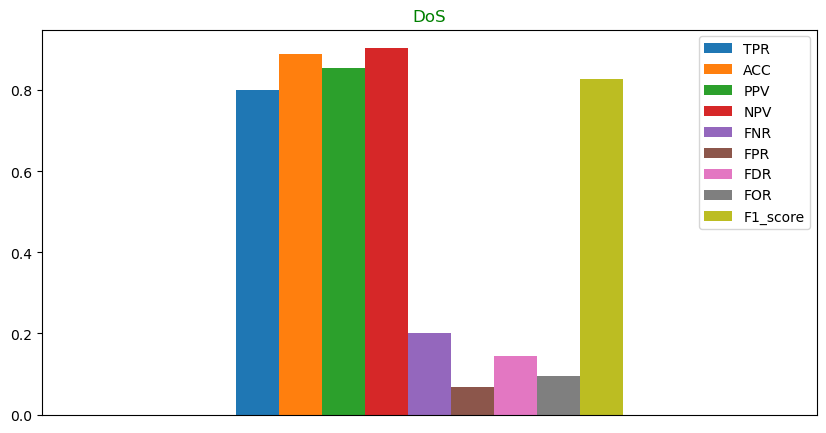

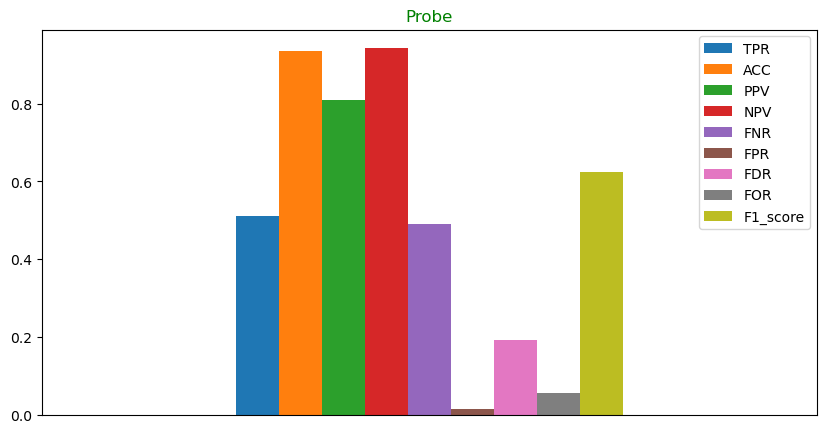

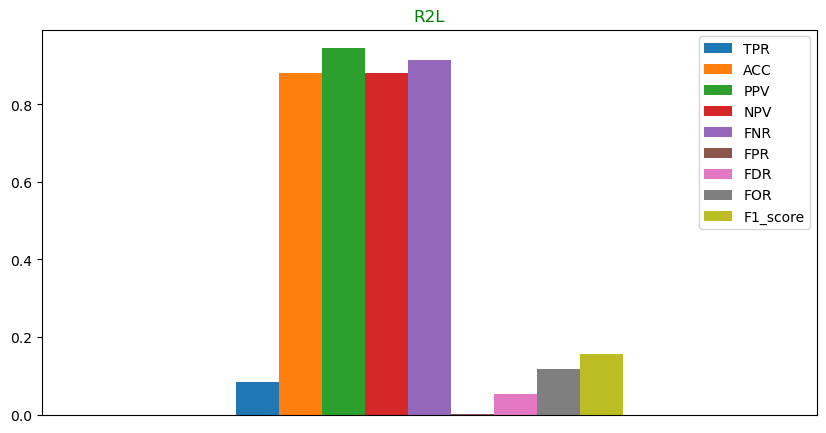

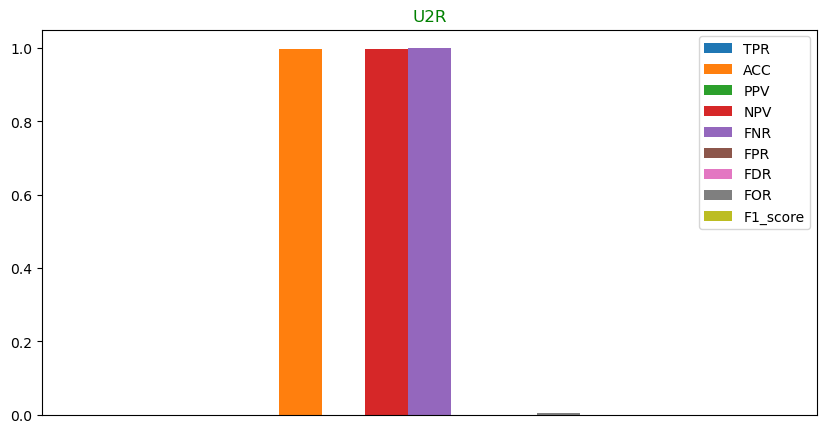

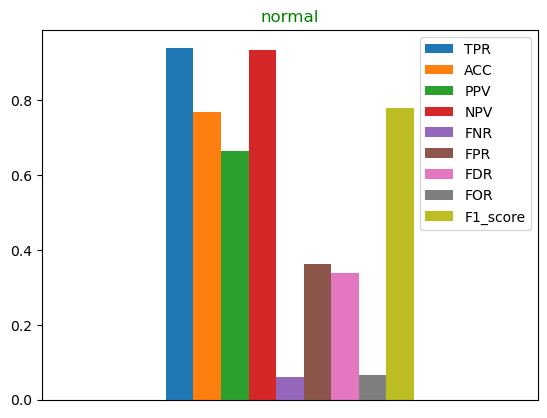

In [59]:
normal = {}
DoS = {}
Probe = {}
R2L = {}
U2R = {}

list_label = [normal, DoS, Probe, R2L, U2R]
sum_matrix = sum(sum(cm))
for c in range(len(list_label)):
    # True positive - số record mô hình dự đoán là attack giống như trong test dataset, dương tính đúng, dương tính thực
    tp = cm[c,c]
    # False positive - số record mô hình dự đoán là attack mà trong test dataset là normal, dương tính sai, dương tính giả
    fp = sum(cm[:,c]) - cm[c,c]
    # False negative - số record mô hình dự đoán là normal mà trong test dataset là attack, âm tính sai, âm tính giả
    fn = sum(cm[c,:]) - cm[c,c]
    # True negative - số record mô hình dự đoán là normal giống như trong test dataset, âm tính đúng, âm tính thật
    tn = sum_matrix - tp - fp - fn
    # Recall - True positive rate - độ nhạy - tỷ lệ dương tính thực
    list_label[c]['TPR'] = tp/(tp+fn)
    # Accuracy - độ chính xác
    list_label[c]['ACC'] = (tp+tn)/(tp+fp+fn+tn)
    # Precision - Positive Predictive Value - tỷ lệ dương tính đoán đúng
    list_label[c]['PPV'] = tp/(tp+fp)
    # Negative Predictive Value - tỷ lệ âm tính đoán đúng
    list_label[c]['NPV'] = tn/(tn+fn)
    # Miss Rate - False Negative Rate- tỷ lệ dương tính giả
    list_label[c]['FNR'] = 1 - list_label[c]['TPR']
    # Fall-out - False Positive Rate - Tỷ lệ âm tính giả 
    list_label[c]['FPR'] = fp/(fp+tn)
    # False Discovery Rate - tỷ lệ đoán dương tính sai
    list_label[c]['FDR'] = 1 - list_label[c]['PPV']
    # False Omission Rate - tỷ lệ đoán âm tính sai
    list_label[c]['FOR'] = 1 - list_label[c]['NPV']
    # F1 score - điểm F1 - điểm trung bình hài hòa giữa Precision và Recall
    list_label[c]['F1_score'] = (2*list_label[c]['PPV']*list_label[c]['TPR'])/(list_label[c]['PPV'] + list_label[c]['TPR'])
list_tt = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
for c in range(len(list_label)):

  normal = [list_label[c]]
  df = pd.DataFrame(normal)
  print(df)
  df.plot(kind='bar')
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.title(label=list_tt[c], color="green")
  plt.xlabel('') 
  plt.xticks([])
  plt.figure(1)
  plt.plot()

So với Hidden Markov Model (HMM) khi áp dụng Confusion Matrix, Covolutional Neural Network có độ chính xác (Accuracy) cao hơn

In [60]:
avg_acc = 0
for item in list_label:
    avg_acc+=item["ACC"]
avg_acc/=5
print("Average of Accuracy:",avg_acc)

Average of Accuracy: 0.8941270404542229


# END: CONFUSION MATRIX